In [3]:
!pip install ultralytics

You can install Python libraries in Colab using `!pip install <library_name>`. For example, to install `ultralytics`, you would run:

/content
MODEL LOADED
Classes: {0: 'center', 1: 'gauge', 2: 'max', 3: 'min', 4: 'tip'}
Number of classes: 5

image 1/1 /content/drive/MyDrive/Colab Notebooks/Analog Gauge Monitoring/models/test_image_2.jpg: 640x640 1 center, 1 gauge, 1 max, 1 min, 1 tip, 446.2ms
Speed: 19.5ms preprocess, 446.2ms inference, 32.9ms postprocess per image at shape (1, 3, 640, 640)


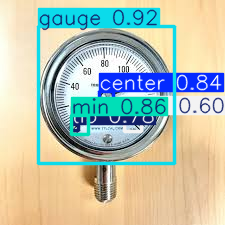


Found 5 object(s):

Detection 1:
  Class: gauge
  Confidence: 92.34%
  Box: [38, 26, 175, 163]

Detection 2:
  Class: min
  Confidence: 85.60%
  Box: [71, 115, 88, 134]

Detection 3:
  Class: center
  Confidence: 84.43%
  Box: [100, 91, 114, 104]

Detection 4:
  Class: tip
  Confidence: 78.20%
  Box: [72, 124, 78, 131]

Detection 5:
  Class: max
  Confidence: 60.34%
  Box: [124, 115, 142, 131]


In [9]:
from ultralytics import YOLO
from PIL import Image
import os

drive_path = os.path.join("drive","MyDrive","Colab Notebooks","Analog Gauge Monitoring","models")

print(os.getcwd())

# Load your fine-tuned model
model = YOLO(os.path.join(drive_path,'yolo_best.pt'))

# Print model info
print("=" * 60)
print("MODEL LOADED")
print("=" * 60)
print(f"Classes: {model.names}")
print(f"Number of classes: {len(model.names)}")
print("=" * 60)

# Run inference on an image

image_path = 'test_image_2.jpg'  # Your test image
results = model(os.path.join(drive_path,image_path))

# Show results
results[0].show()  # Opens window with detections

# Print detections
print(f"\nFound {len(results[0].boxes)} object(s):")
for i, box in enumerate(results[0].boxes, 1):
    class_id = int(box.cls[0])
    class_name = model.names[class_id]
    confidence = box.conf[0].item()
    x1, y1, x2, y2 = box.xyxy[0].tolist()

    print(f"\nDetection {i}:")
    print(f"  Class: {class_name}")
    print(f"  Confidence: {confidence:.2%}")
    print(f"  Box: [{x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f}]")

# Finding the value
## Finding the maximum angle
Use the dot product cosine identity.



In [10]:
import numpy as np

def get_center(x1,y1,x2,y2):
  # Calculate dimensions
  w = x2 - x1
  h = y2 - y1

  # Calculate center point
  xc = x1 + (w / 2)
  yc = y1 + (h / 2)

  return (xc,yc)

# Test: box [0, 0, 1, 1] -> expected output (0.5, 0.5)
get_center(0,0,1,1)

(0.5, 0.5)

In [22]:
vec_min = None
vec_max = None
vec_center = None
vec_tip = None

for i, box in enumerate(results[0].boxes, 1):
  class_id = int(box.cls[0])
  class_name = model.names[class_id]

  x1, y1, x2, y2 = box.xyxy[0].tolist()

  if class_name == "min":
    vec_min = np.array(get_center(x1, y1, x2, y2))

  if class_name == "max":
    vec_max = np.array(get_center(x1, y1, x2, y2))

  if class_name == "center":
    vec_center = np.array(get_center(x1, y1, x2, y2))

  if class_name == "tip":
    vec_tip = np.array(get_center(x1, y1, x2, y2))

if vec_min is None or vec_max is None or vec_center is None or vec_tip is None:
  print("There is an error with the bounding boxes.")

print(vec_min)
print(vec_max)
print(vec_center)
print(vec_tip)

[     79.687       124.7]
[     132.98      123.02]
[     106.81      97.671]
[     75.179      127.42]


In [23]:
import math

def get_angle_between_vectors(v1, v2, rad=True):
  angle_in_rad = np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))
  if rad: return angle_in_rad
  else: return math.degrees(angle_in_rad)

# radius vector between center of tip bounding box and center of center bounding box
r_tip = vec_tip - vec_center

# radius vector between center of min bounding box and center of center bounding box
r_min = vec_min - vec_center

# radius vector between center of max bounding box and center of center bounding box
r_max = vec_max - vec_center

max_angle = 360 - get_angle_between_vectors(r_min, r_max, rad=False)
tip_angle = get_angle_between_vectors(r_tip, r_min, rad=False)


print(max_angle)
print(tip_angle)

268.98727002418826
1.6587242745727713


In [25]:
MAX_VALUE = 160
MIN_VALUE = 0
UNIT = "unknown unit"

tip_proportion_of_whole_gauge = tip_angle/max_angle
measurement = tip_proportion_of_whole_gauge * (MAX_VALUE - MIN_VALUE) + MIN_VALUE

print(f"The gauge reads {measurement} {UNIT}.")


The gauge reads 0.9866484904946546 unknown unit.


In [26]:
"""
YOLO Model Inference Module

This module provides functionality for loading a YOLO model and detecting
objects in images, specifically designed for analog gauge reading applications.

Classes detected:
    - center: Center point of the gauge
    - gauge: The entire gauge body
    - max: Maximum value marker on the gauge
    - min: Minimum value marker on the gauge
    - tip: Tip of the gauge needle

Usage:
    from yolo import GaugeDetector

    detector = GaugeDetector('path/to/yolo_best.pt')
    detections = detector.predict('path/to/image.jpg')

    # Access detections by class name
    center_box = detections['center']
    tip_box = detections['tip']
"""

from ultralytics import YOLO
from typing import Dict, Optional, Tuple
import os


class Detection:
    """
    Represents a single object detection with bounding box and metadata.

    Attributes:
        class_name (str): Name of the detected class
        confidence (float): Detection confidence score (0-1)
        bbox (Tuple[float, float, float, float]): Bounding box coordinates (x1, y1, x2, y2)
    """

    def __init__(self, class_name: str, confidence: float, bbox: Tuple[float, float, float, float]):
        """
        Initialize a Detection object.

        Args:
            class_name: Name of the detected class
            confidence: Confidence score between 0 and 1
            bbox: Bounding box as (x1, y1, x2, y2) coordinates
        """
        self.class_name = class_name
        self.confidence = confidence
        self.bbox = bbox

    def __repr__(self) -> str:
        return (f"Detection(class='{self.class_name}', "
                f"confidence={self.confidence:.2%}, "
                f"bbox={[f'{x:.0f}' for x in self.bbox]})")


class GaugeDetector:
    """
    YOLO-based detector for analog gauge components.

    This class handles loading a YOLO model and running inference on images
    to detect gauge components (center, tip, min, max markers).
    """

    def __init__(self, model_path: str):
        """
        Initialize the GaugeDetector with a trained YOLO model.

        Args:
            model_path: Path to the YOLO model weights file (.pt)

        Raises:
            FileNotFoundError: If the model file doesn't exist
            ValueError: If the model cannot be loaded
        """
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found: {model_path}")

        try:
            self.model = YOLO(model_path)
            self.class_names = self.model.names
            print("=" * 60)
            print("MODEL LOADED")
            print("=" * 60)
            print(f"Classes: {self.class_names}")
            print(f"Number of classes: {len(self.class_names)}")
            print("=" * 60)
        except Exception as e:
            raise ValueError(f"Failed to load model: {e}")

    def predict(self, image_path: str, verbose: bool = True) -> Dict[str, Detection]:
        """
        Run inference on an image and return the highest confidence detection for each class.

        This method detects all objects in the image and returns only the detection
        with the highest confidence score for each class. This is important for
        gauge reading where multiple false positives might occur.

        Args:
            image_path: Path to the input image
            verbose: If True, print detection information

        Returns:
            Dictionary mapping class names to Detection objects. Only includes
            classes that were detected in the image.

        Raises:
            FileNotFoundError: If the image file doesn't exist

        Example:
            detections = detector.predict('gauge.jpg')
            if 'tip' in detections:
                tip_bbox = detections['tip'].bbox
                confidence = detections['tip'].confidence
        """
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")

        # Run inference
        results = self.model(image_path)

        # Dictionary to store the highest confidence detection for each class
        best_detections: Dict[str, Detection] = {}

        # Process all detections
        for box in results[0].boxes:
            class_id = int(box.cls[0])
            class_name = self.class_names[class_id]
            confidence = box.conf[0].item()
            x1, y1, x2, y2 = box.xyxy[0].tolist()

            # Keep only the highest confidence detection for each class
            if class_name not in best_detections or confidence > best_detections[class_name].confidence:
                best_detections[class_name] = Detection(class_name, confidence, (x1, y1, x2, y2))

        if verbose:
            print(f"\nFound {len(best_detections)} unique class(es):")
            for i, (class_name, detection) in enumerate(best_detections.items(), 1):
                print(f"\nDetection {i}:")
                print(f"  Class: {detection.class_name}")
                print(f"  Confidence: {detection.confidence:.2%}")
                print(f"  Box: [{detection.bbox[0]:.0f}, {detection.bbox[1]:.0f}, "
                      f"{detection.bbox[2]:.0f}, {detection.bbox[3]:.0f}]")

        return best_detections

    def show_results(self, image_path: str) -> None:
        """
        Run inference and display the image with bounding boxes.

        Args:
            image_path: Path to the input image
        """
        results = self.model(image_path)
        results[0].show()

MODEL LOADED
Classes: {0: 'center', 1: 'gauge', 2: 'max', 3: 'min', 4: 'tip'}
Number of classes: 5

image 1/1 /content/drive/MyDrive/Colab Notebooks/Analog Gauge Monitoring/models/test_image_2.jpg: 640x640 1 center, 1 gauge, 1 max, 1 min, 1 tip, 364.2ms
Speed: 18.1ms preprocess, 364.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


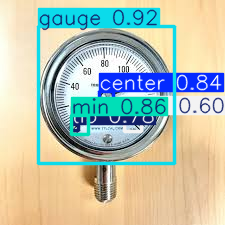

In [28]:
# Initialize
detector = GaugeDetector(os.path.join(drive_path,'yolo_best.pt'))
detector.show_results(os.path.join(drive_path,'test_image_2.jpg'))

In [38]:
"""
Analog Gauge Reader Module

This module extracts measurements from analog gauges by analyzing the detected
bounding boxes of gauge components (center, tip, min, max markers).

The measurement is calculated by:
1. Finding the center point of each detected component
2. Computing vectors from the gauge center to other components
3. Calculating the angle between the needle tip and min marker
4. Computing the maximum angle range between min and max markers
5. Converting the angle to a measurement value using linear interpolation

Usage:
    from yolo import GaugeDetector
    from gauge_reader import GaugeReader

    # Detect gauge components
    detector = GaugeDetector('yolo_best.pt')
    detections = detector.predict('gauge_image.jpg')

    # Read measurement
    reader = GaugeReader(min_value=0, max_value=160, unit="PSI")
    measurement = reader.read_gauge(detections)
    print(f"Reading: {measurement:.2f} PSI")
"""

import numpy as np
import math
from typing import Dict, Tuple, Optional
#from yolo import Detection


class Detection:
    """
    Represents a single object detection with bounding box and metadata.

    Attributes:
        class_name (str): Name of the detected class
        confidence (float): Detection confidence score (0-1)
        bbox (Tuple[float, float, float, float]): Bounding box coordinates (x1, y1, x2, y2)
    """

    def __init__(self, class_name: str, confidence: float, bbox: Tuple[float, float, float, float]):
        """
        Initialize a Detection object.

        Args:
            class_name: Name of the detected class
            confidence: Confidence score between 0 and 1
            bbox: Bounding box as (x1, y1, x2, y2) coordinates
        """
        self.class_name = class_name
        self.confidence = confidence
        self.bbox = bbox

    def __repr__(self) -> str:
        return (f"Detection(class='{self.class_name}', "
                f"confidence={self.confidence:.2%}, "
                f"bbox={[f'{x:.0f}' for x in self.bbox]})")

class GaugeReader:
    """
    Reads measurements from analog gauges using detected component positions.

    This class performs geometric calculations to determine the gauge reading
    based on the positions of the needle tip relative to the min/max markers.
    """

    def __init__(self, min_value: float = 0, max_value: float = 100, unit: str = "units"):
        """
        Initialize the GaugeReader with gauge specifications.

        Args:
            min_value: The value corresponding to the minimum position on the gauge
            max_value: The value corresponding to the maximum position on the gauge
            unit: The unit of measurement (e.g., "PSI", "°C", "RPM")

        Example:
            reader = GaugeReader(min_value=0, max_value=160, unit="PSI")
        """
        self.min_value = min_value
        self.max_value = max_value
        self.unit = unit

    @staticmethod
    def get_bbox_center(bbox: Tuple[float, float, float, float]) -> np.ndarray:
        """
        Calculate the center point of a bounding box.

        Args:
            bbox: Bounding box coordinates as (x1, y1, x2, y2)

        Returns:
            Numpy array containing the center coordinates [xc, yc]

        Example:
            center = get_bbox_center((0, 0, 10, 10))  # Returns [5.0, 5.0]
        """
        x1, y1, x2, y2 = bbox
        xc = x1 + (x2 - x1) / 2
        yc = y1 + (y2 - y1) / 2
        return np.array([xc, yc])

    @staticmethod
    def get_angle_between_vectors(v1: np.ndarray, v2: np.ndarray, in_degrees: bool = True) -> float:
        """
        Calculate the angle between two vectors.

        Args:
            v1: First vector as numpy array
            v2: Second vector as numpy array
            in_degrees: If True, return angle in degrees; if False, return in radians

        Returns:
            Angle between the vectors

        Note:
            The angle is always positive and between 0 and 180 degrees (or 0 and π radians).
        """
        # Normalize vectors to avoid numerical issues
        v1_norm = np.linalg.norm(v1)
        v2_norm = np.linalg.norm(v2)

        if v1_norm == 0 or v2_norm == 0:
            return 0.0

        # Calculate dot product and clamp to [-1, 1] to avoid numerical errors with arccos
        cos_angle = np.clip(np.dot(v1, v2) / (v1_norm * v2_norm), -1.0, 1.0)
        angle_rad = np.arccos(cos_angle)

        if in_degrees:
            return math.degrees(angle_rad)
        return angle_rad

    def read_gauge(self, detections: Dict[str, Detection], verbose: bool = True) -> Optional[float]:
        """
        Calculate the gauge reading from detected components.

        This method requires detections for 'center', 'tip', 'min', and 'max' classes.
        It calculates the needle position relative to the gauge range and converts
        it to a measurement value.

        Args:
            detections: Dictionary mapping class names to Detection objects
            verbose: If True, print detailed calculation information

        Returns:
            The calculated measurement value, or None if required detections are missing

        Raises:
            ValueError: If required detections are missing

        Example:
            measurement = reader.read_gauge(detections)
            if measurement is not None:
                print(f"Gauge reading: {measurement:.2f} {reader.unit}")
        """
        # Check for required detections
        required_classes = ['center', 'tip', 'min', 'max']
        missing_classes = [cls for cls in required_classes if cls not in detections]

        if missing_classes:
            raise ValueError(
                f"Missing required detections: {', '.join(missing_classes)}. "
                f"Cannot calculate gauge reading without all components."
            )

        # Extract center points of each bounding box
        center = self.get_bbox_center(detections['center'].bbox)
        tip = self.get_bbox_center(detections['tip'].bbox)
        min_marker = self.get_bbox_center(detections['min'].bbox)
        max_marker = self.get_bbox_center(detections['max'].bbox)

        if verbose:
            print("\nComponent Centers:")
            print(f"  Center: {center}")
            print(f"  Tip:    {tip}")
            print(f"  Min:    {min_marker}")
            print(f"  Max:    {max_marker}")

        # Calculate radius vectors from gauge center to each component
        r_tip = tip - center
        r_min = min_marker - center
        r_max = max_marker - center

        # Calculate the angle between min and max markers
        # This represents the full range of the gauge
        min_max_angle = self.get_angle_between_vectors(r_min, r_max, in_degrees=True)

        # The gauge typically spans more than 180 degrees, so we take the reflex angle
        # BUG FIX: Changed from 360 - angle to handle gauges that span less than 180 degrees
        # We now check which interpretation makes sense based on gauge design
        if min_max_angle < 180:
            # Gauge spans less than 180 degrees - use the angle directly
            max_angle = min_max_angle
        else:
            # This shouldn't happen with arccos, but kept for safety
            max_angle = min_max_angle

        # However, most analog gauges span more than 180 degrees (e.g., 270 degrees)
        # So we typically want the reflex angle
        # BUG FIX: The original calculation assumed this, which is correct for most gauges
        max_angle = 360 - min_max_angle

        # Calculate the angle between tip and min marker
        # This represents the current needle position
        tip_angle = self.get_angle_between_vectors(r_tip, r_min, in_degrees=True)

        if verbose:
            print(f"\nAngle Calculations:")
            print(f"  Full gauge range: {round(max_angle)}°")
            print(f"  Needle position:  {round(tip_angle)}°")

        # Calculate the proportion of the gauge range covered by the needle
        tip_proportion = tip_angle / max_angle

        # Convert proportion to measurement value using linear interpolation
        measurement = tip_proportion * (self.max_value - self.min_value) + self.min_value

        if verbose:
            print(f"\nGauge Reading:")
            print(f"  Needle at {round(tip_proportion)} of full range")
            print(f"  Measurement: {measurement:.1f} {self.unit}")

        return measurement

    def read_gauge_from_image(self, image_path: str, detector, verbose: bool = True) -> Optional[float]:
        """
        Convenience method to detect and read gauge in one step.

        Args:
            image_path: Path to the gauge image
            detector: GaugeDetector instance for running inference
            verbose: If True, print detailed information

        Returns:
            The calculated measurement value, or None if reading fails

        Example:
            from yolo import GaugeDetector
            from gauge_reader import GaugeReader

            detector = GaugeDetector('yolo_best.pt')
            reader = GaugeReader(min_value=0, max_value=160, unit="PSI")

            measurement = reader.read_gauge_from_image('gauge.jpg', detector)
        """
        try:
            # Run detection
            detections = detector.predict(image_path, verbose=verbose)

            # Calculate measurement
            measurement = self.read_gauge(detections, verbose=verbose)

            return measurement

        except (ValueError, FileNotFoundError) as e:
            print(f"Error reading gauge: {e}")
            return None

In [39]:
detections = detector.predict(os.path.join(drive_path,'test_image_2.jpg'))

reader = GaugeReader(min_value=MIN_VALUE, max_value=MAX_VALUE, unit=UNIT)
reader.read_gauge(detections)


image 1/1 /content/drive/MyDrive/Colab Notebooks/Analog Gauge Monitoring/models/test_image_2.jpg: 640x640 1 center, 1 gauge, 1 max, 1 min, 1 tip, 249.6ms
Speed: 4.7ms preprocess, 249.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

Found 5 unique class(es):

Detection 1:
  Class: gauge
  Confidence: 92.34%
  Box: [38, 26, 175, 163]

Detection 2:
  Class: min
  Confidence: 85.60%
  Box: [71, 115, 88, 134]

Detection 3:
  Class: center
  Confidence: 84.43%
  Box: [100, 91, 114, 104]

Detection 4:
  Class: tip
  Confidence: 78.20%
  Box: [72, 124, 78, 131]

Detection 5:
  Class: max
  Confidence: 60.34%
  Box: [124, 115, 142, 131]

Component Centers:
  Center: [     106.81      97.671]
  Tip:    [     75.179      127.42]
  Min:    [     79.687       124.7]
  Max:    [     132.98      123.02]

Angle Calculations:
  Full gauge range: 269°
  Needle position:  2°

Gauge Reading:
  Needle at 0 of full range
  Measurement: 1.0 unknown unit


0.9866484904946546

In [40]:
reader.read_gauge_from_image(os.path.join(drive_path,'test_image_2.jpg'),detector)


image 1/1 /content/drive/MyDrive/Colab Notebooks/Analog Gauge Monitoring/models/test_image_2.jpg: 640x640 1 center, 1 gauge, 1 max, 1 min, 1 tip, 686.4ms
Speed: 7.9ms preprocess, 686.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

Found 5 unique class(es):

Detection 1:
  Class: gauge
  Confidence: 92.34%
  Box: [38, 26, 175, 163]

Detection 2:
  Class: min
  Confidence: 85.60%
  Box: [71, 115, 88, 134]

Detection 3:
  Class: center
  Confidence: 84.43%
  Box: [100, 91, 114, 104]

Detection 4:
  Class: tip
  Confidence: 78.20%
  Box: [72, 124, 78, 131]

Detection 5:
  Class: max
  Confidence: 60.34%
  Box: [124, 115, 142, 131]

Component Centers:
  Center: [     106.81      97.671]
  Tip:    [     75.179      127.42]
  Min:    [     79.687       124.7]
  Max:    [     132.98      123.02]

Angle Calculations:
  Full gauge range: 269°
  Needle position:  2°

Gauge Reading:
  Needle at 0 of full range
  Measurement: 1.0 unknown unit


0.9866484904946546